In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import torch
import random
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from EEG_transformer_code.method_A.model import EEGT
import EEG_transformer_code.method_A.params_full_c as params
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
warnings.filterwarnings('ignore')

# Configurations

In [2]:
data_path = './dataset'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
cross = 20
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

cuda:1


# SVM

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.show()

In [4]:
data_list = os.listdir(data_path)
acc_tests_SVM = []
f1_tests_SVM = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label, test_data, test_label = traindata[:,:-1], traindata[:,-1], testdata[:,:-1], testdata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        classifier = svm.SVC(C=1,kernel='rbf')
        classifier.fit(train_data, train_label)
        tests.append(classifier.score(test_data, test_label))
        tests_f1.append(f1_score(test_label, classifier.predict(test_data)))
        # if i == cross-1:
        #     plot_confusion_matrix(test_label.tolist(), classifier.predict(test_data).tolist(), ['0', '1'], False, 'SVM')
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_SVM.append(acc_test*100)
    f1_tests_SVM.append(f1_test*100)

Begin to process person huangsiye_20210529_1.
Acc of test set: 0.97083
F1 of test set: 0.98503
Begin to process person huangsiye_20210531_2.
Acc of test set: 0.97361
F1 of test set: 0.98660
Begin to process person huangsiye_20210604_3.
Acc of test set: 0.86128
F1 of test set: 0.92285
Begin to process person liangjie_20210424_2.
Acc of test set: 0.74826
F1 of test set: 0.83242
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 0.77899
F1 of test set: 0.86790
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 0.79882
F1 of test set: 0.87908
Begin to process person tana_20210425_1.
Acc of test set: 0.97689
F1 of test set: 0.98827
Begin to process person zengcheng_20210615_1.
Acc of test set: 0.78295
F1 of test set: 0.86306
Begin to process person zengjingyao_20210604_2.
Acc of test set: 0.85598
F1 of test set: 0.92008
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 0.76542
F1 of test set: 0.85434
Begin to process person zhengwenxin_20210429_2.
Acc 

# Logistic Regression

In [5]:
data_list = os.listdir(data_path)
acc_tests_LR = []
f1_tests_LR = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label, test_data, test_label = traindata[:,:-1], traindata[:,-1], testdata[:,:-1], testdata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        classifier = LogisticRegression(penalty="l2", C=0.5, solver="liblinear")
        classifier.fit(train_data, train_label)
        tests.append(classifier.score(test_data, test_label))
        tests_f1.append(f1_score(test_label, classifier.predict(test_data)))
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_LR.append(acc_test*100)
    f1_tests_LR.append(f1_test*100)

Begin to process person huangsiye_20210529_1.
Acc of test set: 0.97596
F1 of test set: 0.98768
Begin to process person huangsiye_20210531_2.
Acc of test set: 0.97056
F1 of test set: 0.98502
Begin to process person huangsiye_20210604_3.
Acc of test set: 0.92801
F1 of test set: 0.96244
Begin to process person liangjie_20210424_2.
Acc of test set: 0.77452
F1 of test set: 0.85650
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 0.79181
F1 of test set: 0.87757
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 0.81037
F1 of test set: 0.88901
Begin to process person tana_20210425_1.
Acc of test set: 0.97076
F1 of test set: 0.98511
Begin to process person zengcheng_20210615_1.
Acc of test set: 0.78183
F1 of test set: 0.86769
Begin to process person zengjingyao_20210604_2.
Acc of test set: 0.89020
F1 of test set: 0.94045
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 0.83222
F1 of test set: 0.90438
Begin to process person zhengwenxin_20210429_2.
Acc 

# Multi-layer Perceptron

In [6]:
class MLP(nn.Module):
    def __init__(self, num_classes=2):
        super(MLP, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(310, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [7]:
def Validation(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100, f1 * 100

In [8]:
data_list = os.listdir(data_path)
acc_tests_MLP = []
f1_tests_MLP = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = traindata[:,:-1], traindata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        train_data, train_label = torch.from_numpy(train_data).float(), torch.from_numpy(train_label)
        test_data, test_label = testdata[:,:-1], testdata[:,-1]
        test_data, test_label = torch.from_numpy(test_data).float(), torch.from_numpy(test_label)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = MLP().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_MLP.append(acc_test)
    f1_tests_MLP.append(f1_test)

Begin to process person huangsiye_20210529_1.


Acc of test set: 93.04369
F1 of test set: 93.11169
Begin to process person huangsiye_20210531_2.
Acc of test set: 87.83114
F1 of test set: 88.69196
Begin to process person huangsiye_20210604_3.
Acc of test set: 95.28867
F1 of test set: 98.17956
Begin to process person liangjie_20210424_2.
Acc of test set: 77.13178
F1 of test set: 79.86691
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 82.43471
F1 of test set: 85.66006
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 80.51431
F1 of test set: 82.56052
Begin to process person tana_20210425_1.
Acc of test set: 88.50121
F1 of test set: 89.42356
Begin to process person zengcheng_20210615_1.
Acc of test set: 85.03372
F1 of test set: 91.29483
Begin to process person zengjingyao_20210604_2.
Acc of test set: 94.16236
F1 of test set: 95.79627
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 89.38817
F1 of test set: 93.43739
Begin to process person zhengwenxin_20210429_2.
Acc of test set: 84.72562
F1 o

# Convolution Neural Network

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes = 2):
        super(CNN, self).__init__()
        # self.feature_extraction = nn.Sequential(
        #     nn.Conv1d(in_channels = 1, out_channels = 2, kernel_size = 16, padding = 1),
        #     nn.MaxPool1d(kernel_size = 8, stride = 1),
        #     nn.ReLU(),
        #     nn.Conv1d(in_channels = 2, out_channels = 2, kernel_size = 16),
        #     nn.Conv1d(in_channels = 2, out_channels = 4, kernel_size = 16, padding = 1),
        #     nn.ReLU()
        # )  
        # self.classifier = nn.Sequential(
        #     nn.Linear(1048, 2048),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(2048, num_classes)
        # )
        self.feature_extraction = nn.Sequential(
            nn.Conv1d(in_channels = 5, out_channels = 8, kernel_size = 4, padding = 1),
            nn.MaxPool1d(kernel_size = 4, stride = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = 4),
            nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 4, padding = 1),
            nn.ReLU()
        )  
        self.classifier = nn.Sequential(
            nn.Linear(1728, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        x = self.feature_extraction(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
data_list = os.listdir(data_path)
acc_tests_CNN = []
f1_tests_CNN = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = traindata[:,:-1], traindata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        train_data, train_label = torch.from_numpy(train_data).float(), torch.from_numpy(train_label)
        test_data, test_label = testdata[:,:-1], testdata[:,-1]
        test_data, test_label = torch.from_numpy(test_data).float(), torch.from_numpy(test_label)
        train_data = train_data.reshape(train_data.shape[0], 62, 5).permute(0, 2, 1)
        test_data = test_data.reshape(test_data.shape[0], 62, 5).permute(0, 2, 1)
        # train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1).permute(0, 2, 1)
        # test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1).permute(0, 2, 1)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = CNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_CNN.append(acc_test)
    f1_tests_CNN.append(f1_test)

Begin to process person huangsiye_20210529_1.


Acc of test set: 97.90828
F1 of test set: 99.05158
Begin to process person huangsiye_20210531_2.
Acc of test set: 78.16304
F1 of test set: 81.52578
Begin to process person huangsiye_20210604_3.
Acc of test set: 95.43496
F1 of test set: 98.71332
Begin to process person liangjie_20210424_2.
Acc of test set: 81.76698
F1 of test set: 86.15567
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 83.43463
F1 of test set: 83.67445
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 83.80651
F1 of test set: 88.25445
Begin to process person tana_20210425_1.
Acc of test set: 97.62573
F1 of test set: 99.19267
Begin to process person zengcheng_20210615_1.
Acc of test set: 84.94057
F1 of test set: 91.32871
Begin to process person zengjingyao_20210604_2.
Acc of test set: 88.58767
F1 of test set: 92.04813
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 90.00263
F1 of test set: 93.68850
Begin to process person zhengwenxin_20210429_2.
Acc of test set: 86.90906
F1 o

# Recurrent Neural Network

In [11]:
class RNN(nn.Module):
    def __init__(self, hidden_size = 32, num_classes = 2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size = 5, hidden_size = self.hidden_size, num_layers = 2, batch_first = True, bidirectional = True)
        self.classifier = nn.Sequential(
            nn.Linear(62 * self.hidden_size * 2, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
data_list = os.listdir(data_path)
acc_tests_RNN = []
f1_tests_RNN = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = traindata[:,:-1], traindata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        train_data, train_label = torch.from_numpy(train_data).float(), torch.from_numpy(train_label)
        test_data, test_label = testdata[:,:-1], testdata[:,-1]
        test_data, test_label = torch.from_numpy(test_data).float(), torch.from_numpy(test_label)
        train_data = train_data.reshape(train_data.shape[0], 62, 5)
        test_data = test_data.reshape(test_data.shape[0], 62, 5)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = RNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_RNN.append(acc_test)
    f1_tests_RNN.append(f1_test)

Begin to process person huangsiye_20210529_1.


Acc of test set: 97.54477
F1 of test set: 98.87184
Begin to process person huangsiye_20210531_2.
Acc of test set: 97.91078
F1 of test set: 99.08316
Begin to process person huangsiye_20210604_3.
Acc of test set: 95.28216
F1 of test set: 98.05696
Begin to process person liangjie_20210424_2.
Acc of test set: 83.16133
F1 of test set: 81.56382
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 82.45999
F1 of test set: 85.64975
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 88.25653
F1 of test set: 94.26711
Begin to process person tana_20210425_1.
Acc of test set: 98.01926
F1 of test set: 99.34148
Begin to process person zengcheng_20210615_1.
Acc of test set: 75.48846
F1 of test set: 75.85092
Begin to process person zengjingyao_20210604_2.
Acc of test set: 93.96755
F1 of test set: 92.82846
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 89.29995
F1 of test set: 94.05334
Begin to process person zhengwenxin_20210429_2.
Acc of test set: 88.68077
F1 o

# Transformer

In [13]:
def define_model(i):
    return EEGT(
        params.ENC_INPUT_LEN,
        params.CLASSES,
        params.ENC_INPUT_DIM,
        params.ENC_DEPTH[i],
        params.ENC_HEADS,
        params.ENC_MLP_DIM[i],
        params.ENC_POOL,
        params.ENC_DIM_HEAD[i],
        params.ENC_DROPOUT,
        params.ENC_EMB_DROPOUT,
    )

In [14]:
data_list = os.listdir(data_path)
acc_tests_Transformer = []
f1_tests_Transformer = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = traindata[:,:-1], traindata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        train_data, train_label = torch.from_numpy(train_data).float(), torch.from_numpy(train_label)
        test_data, test_label = testdata[:,:-1], testdata[:,-1]
        test_data, test_label = torch.from_numpy(test_data).float(), torch.from_numpy(test_label)
        train_data = train_data.reshape(train_data.shape[0], 62, 5)
        test_data = test_data.reshape(test_data.shape[0], 62, 5)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = define_model(0).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 20
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                net.train()
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_Transformer.append(acc_test)
    f1_tests_Transformer.append(f1_test)

Begin to process person huangsiye_20210529_1.


Acc of test set: 97.54306
F1 of test set: 93.37231
Begin to process person huangsiye_20210531_2.
Acc of test set: 97.95221
F1 of test set: 99.41545
Begin to process person huangsiye_20210604_3.
Acc of test set: 91.07198
F1 of test set: 93.16927
Begin to process person liangjie_20210424_2.
Acc of test set: 84.20614
F1 of test set: 83.26284
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 90.31491
F1 of test set: 93.35769
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 89.52914
F1 of test set: 92.68255
Begin to process person tana_20210425_1.
Acc of test set: 95.91697
F1 of test set: 98.30885
Begin to process person zengcheng_20210615_1.
Acc of test set: 85.50106
F1 of test set: 85.94010
Begin to process person zengjingyao_20210604_2.
Acc of test set: 93.49140
F1 of test set: 96.00539
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 85.34534
F1 of test set: 88.75794
Begin to process person zhengwenxin_20210429_2.
Acc of test set: 88.48844
F1 o

# Comparison of different models

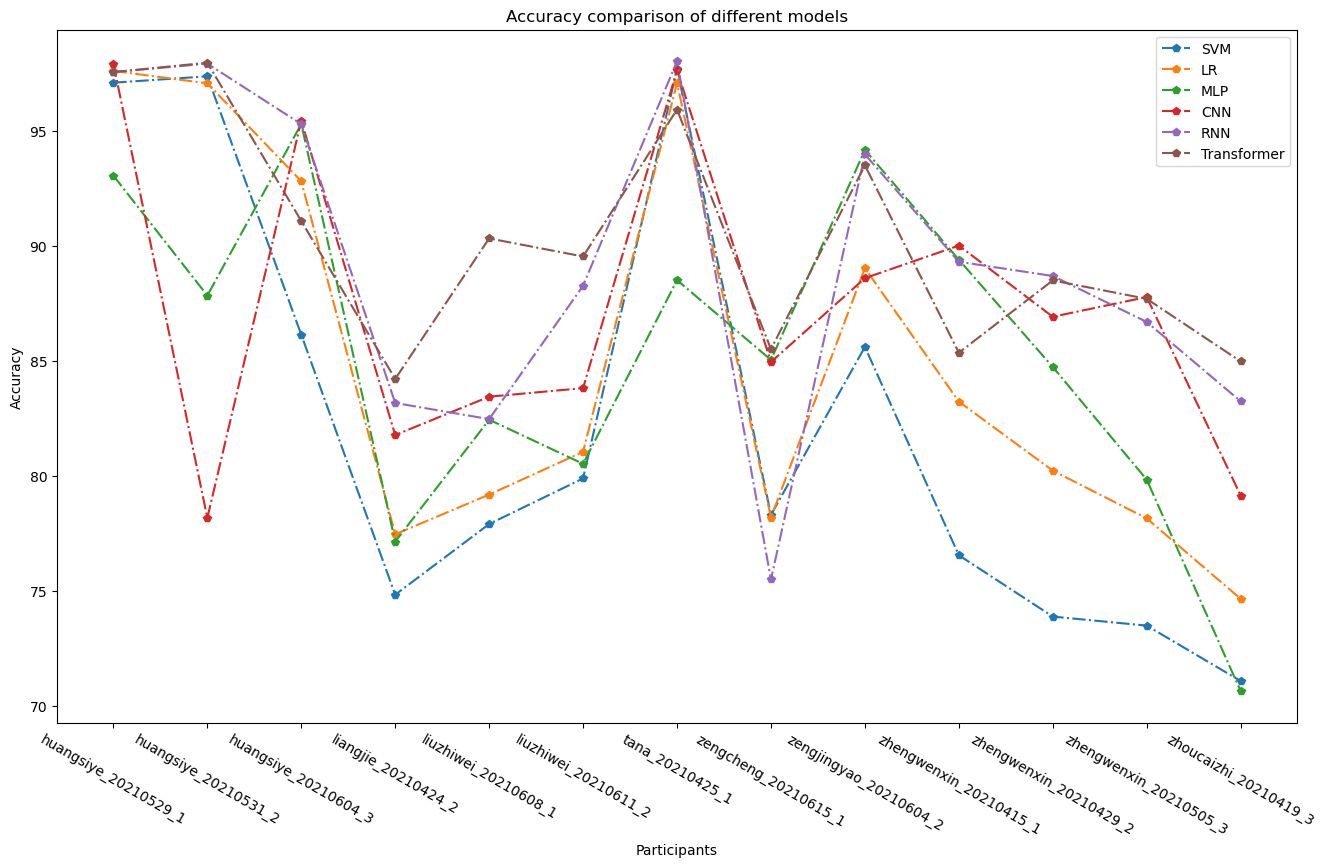

In [15]:
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
plt.title("Accuracy comparison of different models")
x = os.listdir(data_path)
plt.plot(x, acc_tests_SVM, '-.p')
plt.plot(x, acc_tests_LR, '-.p')
plt.plot(x, acc_tests_MLP, '-.p')
plt.plot(x, acc_tests_CNN, '-.p')
plt.plot(x, acc_tests_RNN, '-.p')
plt.plot(x, acc_tests_Transformer, '-.p')
plt.legend(['SVM','LR','MLP','CNN','RNN','Transformer'])
plt.show()

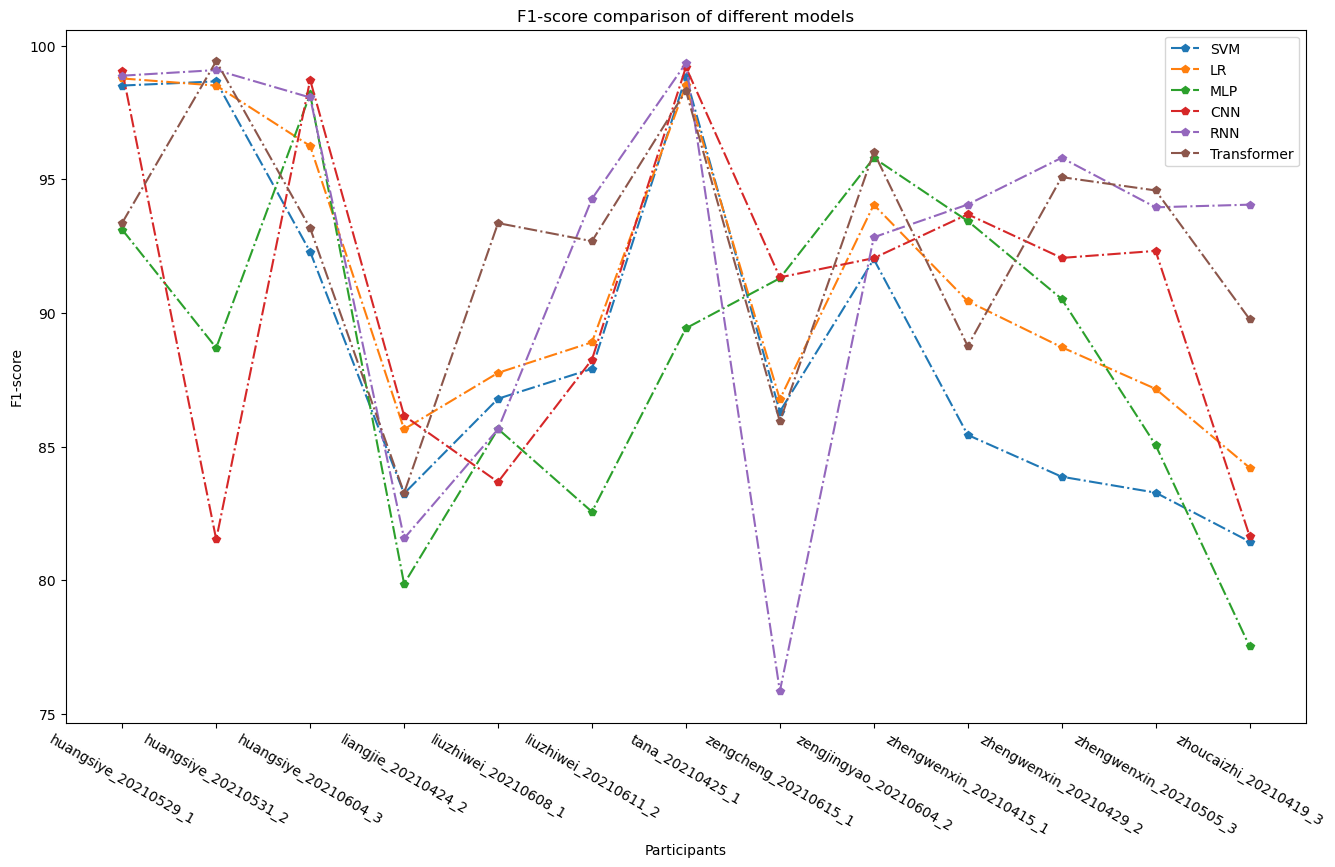

In [16]:
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('F1-score')
plt.title("F1-score comparison of different models")
x = os.listdir(data_path)
plt.plot(x, f1_tests_SVM, '-.p')
plt.plot(x, f1_tests_LR, '-.p')
plt.plot(x, f1_tests_MLP, '-.p')
plt.plot(x, f1_tests_CNN, '-.p')
plt.plot(x, f1_tests_RNN, '-.p')
plt.plot(x, f1_tests_Transformer, '-.p')
plt.legend(['SVM','LR','MLP','CNN','RNN','Transformer'])
plt.show()

[82.28761158432177, 85.04903872102409, 85.2706255110605, 87.34460237276713, 89.22977819261274, 90.1551728003441]
[9.251409947617221, 8.133416083109905, 6.877438731202265, 6.252041169979596, 6.771060815614695, 4.6152970910195315]


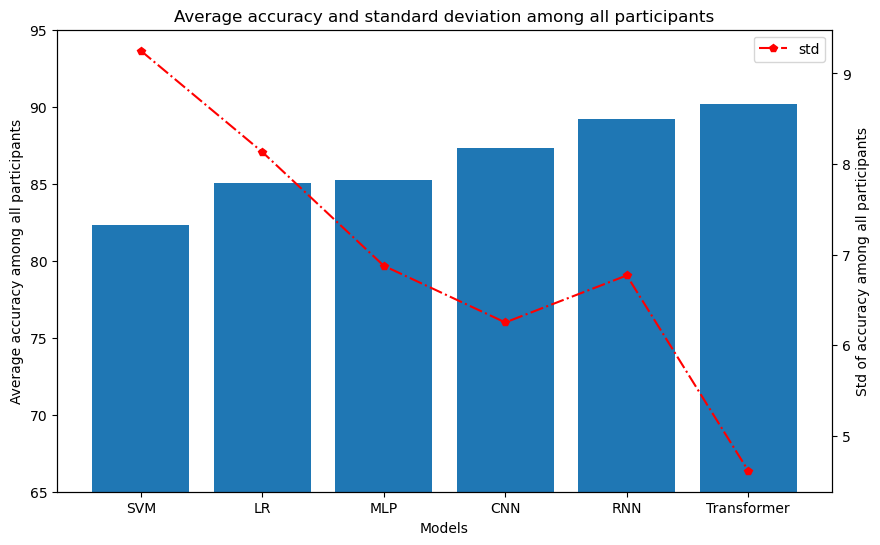

In [17]:
average = [np.mean(acc_tests_SVM), np.mean(acc_tests_LR), np.mean(acc_tests_MLP), 
           np.mean(acc_tests_CNN), np.mean(acc_tests_RNN), np.mean(acc_tests_Transformer)]
std = [np.std(acc_tests_SVM), np.std(acc_tests_LR), np.std(acc_tests_MLP), 
       np.std(acc_tests_CNN), np.std(acc_tests_RNN), np.std(acc_tests_Transformer)]
models = ['SVM','LR','MLP','CNN','RNN','Transformer']
print(average)
print(std)
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.bar(models, average)
ax1.set_xlabel('Models')
ax1.set_ylabel('Average accuracy among all participants')
ax1.set_ybound(65, 95)
ax2 = ax1.twinx()
ax2.plot(models, std, '-.p', color = 'red')
ax2.set_ylabel('Std of accuracy among all participants')
# ax2.set_ybound(2.0, 10.0)
plt.title("Average accuracy and standard deviation among all participants")
plt.legend(['std'])
fig.show()

[89.11987988462312, 91.20532222609752, 88.54862866479712, 90.74363546758966, 92.56655324277075, 92.59211391995797]
[6.0457540178401965, 5.092305830502037, 5.918889531718607, 5.971412105233689, 6.9410806500702815, 4.442053683694723]


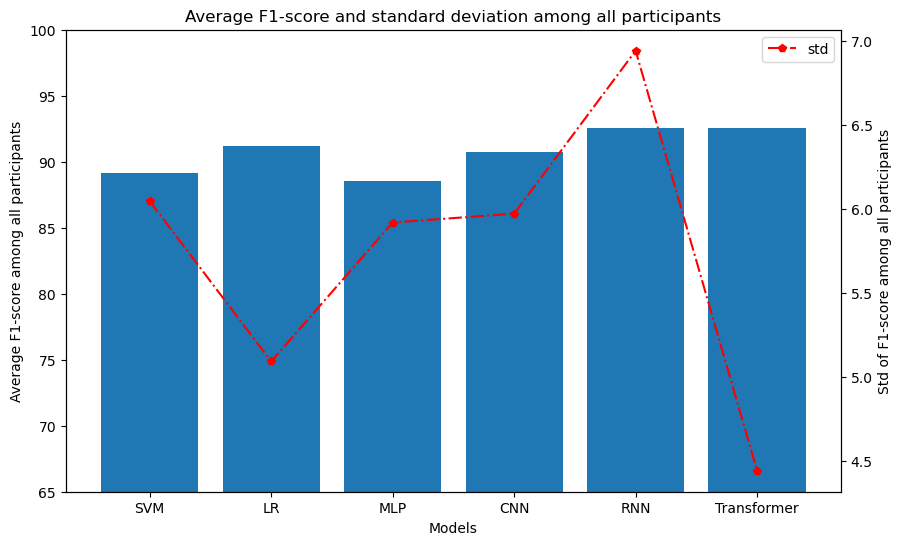

In [18]:
average = [np.mean(f1_tests_SVM), np.mean(f1_tests_LR), np.mean(f1_tests_MLP), 
           np.mean(f1_tests_CNN), np.mean(f1_tests_RNN), np.mean(f1_tests_Transformer)]
std = [np.std(f1_tests_SVM), np.std(f1_tests_LR), np.std(f1_tests_MLP), 
       np.std(f1_tests_CNN), np.std(f1_tests_RNN), np.std(f1_tests_Transformer)]
models = ['SVM','LR','MLP','CNN','RNN','Transformer']
print(average)
print(std)
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.bar(models, average)
ax1.set_xlabel('Models')
ax1.set_ylabel('Average F1-score among all participants')
ax1.set_ybound(65, 100)
ax2 = ax1.twinx()
ax2.plot(models, std, '-.p', color = 'red')
ax2.set_ylabel('Std of F1-score among all participants')
# ax2.set_ybound(2.0, 10.0)
plt.title("Average F1-score and standard deviation among all participants")
plt.legend(['std'])
fig.show()